In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from LB_D2Q9.dimensionless import opencl_dim as lb

We now want to visualize the evolution of the flow...let's see how it goes...

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [7]:
N = 25 # resolution of obstacle: number of grid points over radius

D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -100 # Pa/m

pipe_length = 3*D # meter

# initialize cylinder
cylinder_center = [pipe_length/4, D/2]
cylinder_radius = D/10

sim = lb.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                             N=N, time_prefactor=1.,
                             cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                             two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 0.1
Characteristic T: 0.008
Reynolds number: 156.25
omega 1.92604006163
2d global: (768, 256)
2d local: (32, 32)
3d global: (768, 256, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices
inlet rho: 1.009228288
outlet rho: 1.0


In [8]:
print 'Total num grid points:' , '%.3E' % (sim.nx*sim.ny)

Total num grid points: 1.885E+05


We want to use the cs-205 mask as the obstacle now for fun.

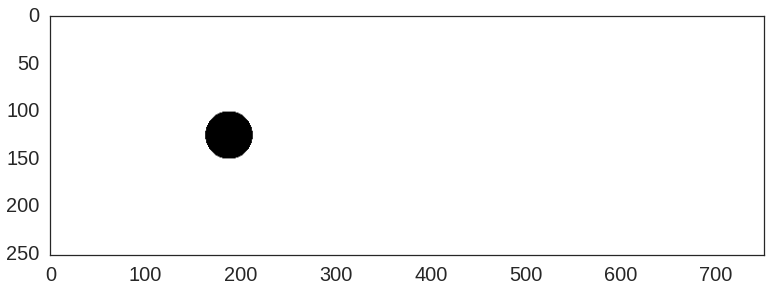

In [9]:
plt.imshow(sim.obstacle_mask_host.T)

In [10]:
import tifffile as tf

In [11]:
cs205_mask = tf.imread('CS205_obstacle_4.tif').astype(np.bool).T

In [12]:
import skimage as ski
import skimage.transform

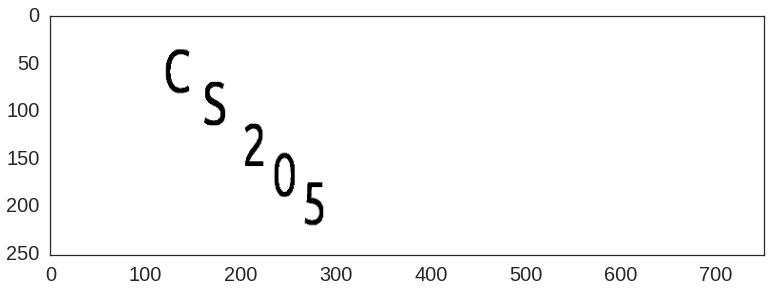

In [13]:
rescaled_mask = ski.transform.resize(cs205_mask, (sim.nx, sim.ny))
plt.imshow(rescaled_mask.T)

Good. The mask is rescaled. We now need to put it into our simulation.

In [14]:
sim.obstacle_mask_host = np.asfortranarray(rescaled_mask.astype(np.int32))
sim.init_hydro()
sim.update_feq()
sim.init_pop()

inlet rho: 1.009228288
outlet rho: 1.0


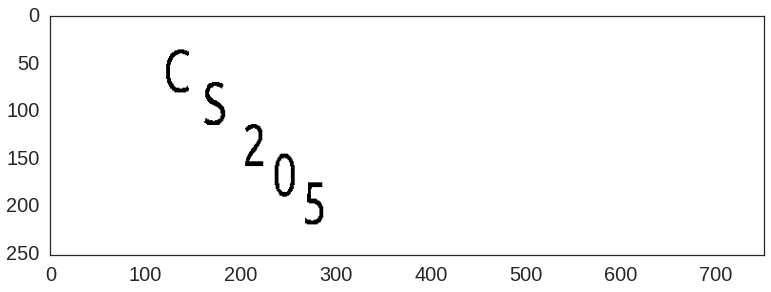

In [15]:
plt.imshow(sim.obstacle_mask_host.T)

Use the internals of our simulation to assign this obstacle mask. A little sloppy.

Good. We kicked a ton of butt. Let's make this into a video now.

In [16]:
total_time_to_run=100

time_per_iteration = .1 #In dimensionless units
steps_per_iteration = int(time_per_iteration/sim.delta_t)
print 'Running for', steps_per_iteration, 'iterations between frames'
print 'Corresponds to a non-dimensional time of ' , time_per_iteration

Running for 62 iterations between frames
Corresponds to a non-dimensional time of  0.1


In [17]:
total_num_steps = int(np.ceil(total_time_to_run/time_per_iteration))

In [18]:
from IPython import display

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

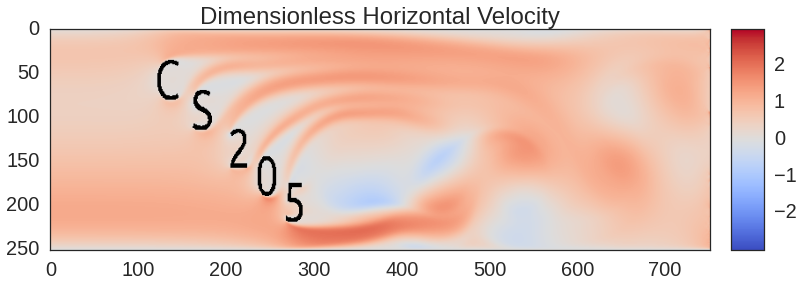

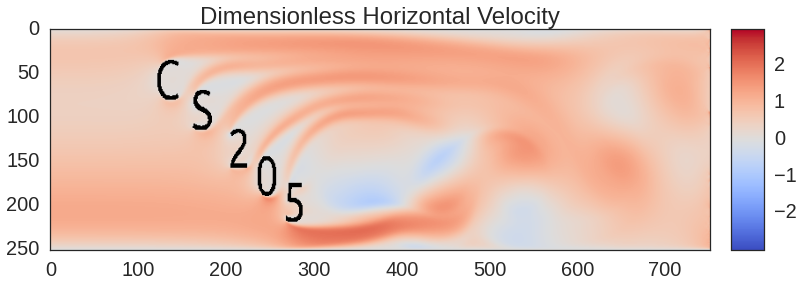

In [20]:
for i in range(total_num_steps):
    plt.clf()

    fields = sim.get_nondim_fields()
    
    u = fields['u']
    u[sim.obstacle_mask_host.astype(np.bool)] = np.nan
    
    cmap = cm.coolwarm    
    cmap.set_bad(color='k', alpha=1.)
    
    im = plt.imshow(fields['u'].T, cmap=cmap, interpolation=None)

    plt.clim(-3, 3)
    plt.title('Dimensionless Horizontal Velocity')
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.3)
    plt.colorbar(im, cax=cax, ticks=[-2,-1,0,1,2])

    plt.savefig('{0:05}'.format(i) + '.png', dpi=200, bbox_inches='tight')
    
    print 'Updated!'
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_iteration)

Ok, this is looking more like it. Good. Let's see how developed the flow is.

IDK how to convert...but let's just fit.

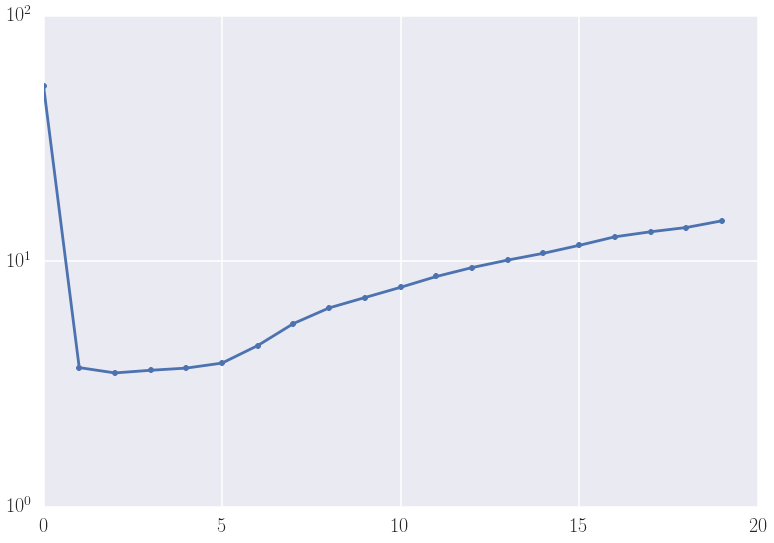

In [47]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

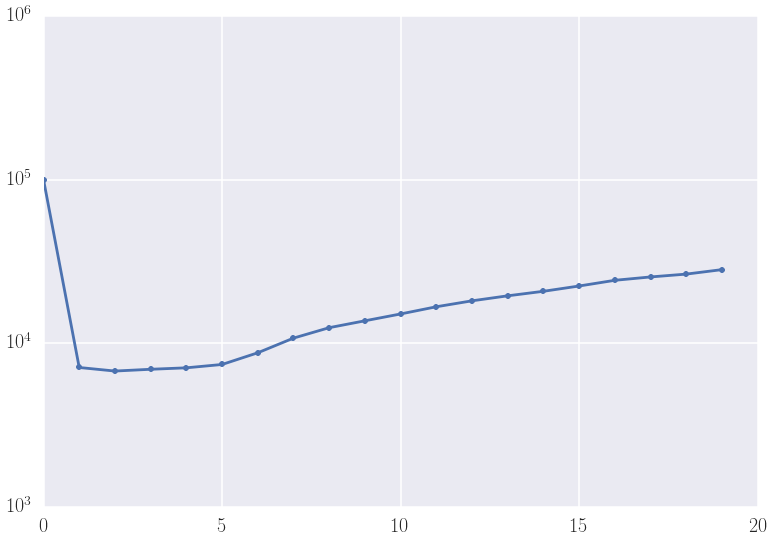

In [48]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!